# Neural Network Project

## Emotion Detection through Speech

##  ECE 5268 Theory and Applications of Neural Networks

**Background**: *Sentiment analysis* is the process of analyzing digital text to determine if the emotional tone of the message is positive, negative, or neutral. More specifically, sentiment analysis is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.

Often times, it is not *what* is said, but *how* it is said. Text-based models may miss this aspect and as such, it may prove useful to also analyze digital voice signals in the same context.

To this end, audio files were analyzed to determine the *mood* of the speaker.

**Data**: Audio datasets with around 2000 audio files which were in the wav format from the following websites:

1) http://neuron.arts.ryerson.ca/ravdess/?f=3,

2) http://kahlan.eps.surrey.ac.uk/savee/Download.html 



### Load `TensorFlow` first!! Apparently, `librosa` screws things up!!

In [4]:
#!pip install --upgrade pip
#!pip install tensorflow
import tensorflow as tf

In [5]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences # *** Fix import ***
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [6]:
import os
import sys

import pandas as pd
import glob 
import numpy as np
import scipy.io.wavfile
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

In [7]:
from sklearn.metrics import confusion_matrix

### Import dataframe (due to `tf` and `librosa` conflict)¶

In [8]:
rnewdf = pd.read_pickle('feature')

### Split the dataframe into *training* and *testing* dataseets

In [9]:
from sklearn.model_selection import train_test_split
X_trainFull, X_testFull = train_test_split(rnewdf,test_size = 0.2, random_state = 42)

In [11]:
print(X_trainFull.shape)
print(X_testFull.shape)

(768, 217)
(192, 217)


## Remove last column from 'Full' dataframe (which contains labels)

In [12]:
X_train = X_trainFull.iloc[:, :-1]
print(X_train.shape)

X_test = X_testFull.iloc[:, :-1]
print(X_test.shape)

(768, 216)
(192, 216)


## Retain last column from 'Full' dataframe (which contains labels)

In [13]:
y_train = X_trainFull.iloc[:, -1:]
print(y_train.shape)

y_test = X_testFull.iloc[:, -1:]
print(y_test.shape)

(768, 1)
(192, 1)


## *One-hot* encoding for categories

In [14]:
#from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

#X_train = np.array(trainfeatures)
#y_train = np.array(trainlabel)
#X_test = np.array(testfeatures)
#y_test = np.array(testlabel)

lb = LabelEncoder()

#y_train = np_utils.to_categorical(lb.fit_transform(y_train))
#y_test = np_utils.to_categorical(lb.fit_transform(y_test))
y_train = keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = keras.utils.to_categorical(lb.fit_transform(y_test))


/Users/alesandrawiecheckivergara/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alesandrawiecheckivergara/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
y_train.shape

(768, 10)

In [16]:
X_train.shape

(768, 216)

## Changing dimension for CNN model

In [17]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn  = np.expand_dims(X_test, axis=2)

In [18]:
print(x_traincnn.shape)
print(x_testcnn.shape)

(768, 216, 1)
(192, 216, 1)


## Required `imports`

In [19]:
import time

## Hung-Puthran [baseline] model: See *Emotion Detection through Speech* document

In [24]:
model = Sequential()
model.add(Conv1D(128, 5,padding='same',input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))

baselineModel = model

#from keras import regularizers
#opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)               # *** deprecated ***
opt = keras.optimizers.RMSprop(learning_rate=0.00001) # took out decay=1e-6
baselineModel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

baselineModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 216, 128)          768       
                                                                 
 activation_7 (Activation)   (None, 216, 128)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 216, 128)          82048     
                                                                 
 activation_8 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout_2 (Dropout)         (None, 216, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 27, 128)           0         
 g1D)                                                            
                                                      

In [25]:
num_epochs = 200

tic = time.perf_counter()
baselineModelHistory=baselineModel.fit(x_traincnn, y_train, batch_size=16, epochs=num_epochs, validation_data=(x_testcnn, y_test))
toc = time.perf_counter()
print(f"Model took {toc - tic:0.4f} seconds to run!")

Epoch 1/200
48/48 [==============================] - 1s 14ms/step - loss: 2.5072 - accuracy: 0.1055 - val_loss: 2.2961 - val_accuracy: 0.1302
Epoch 2/200
48/48 [==============================] - 1s 12ms/step - loss: 2.3792 - accuracy: 0.0859 - val_loss: 2.2734 - val_accuracy: 0.1562
Epoch 3/200
48/48 [==============================] - 1s 15ms/step - loss: 2.3432 - accuracy: 0.1094 - val_loss: 2.2627 - val_accuracy: 0.1094
Epoch 4/200
48/48 [==============================] - 1s 28ms/step - loss: 2.2760 - accuracy: 0.1237 - val_loss: 2.2374 - val_accuracy: 0.1875
Epoch 5/200
48/48 [==============================] - 4s 86ms/step - loss: 2.2816 - accuracy: 0.1367 - val_loss: 2.2397 - val_accuracy: 0.1302
Epoch 6/200
48/48 [==============================] - 3s 59ms/step - loss: 2.2486 - accuracy: 0.1667 - val_loss: 2.2154 - val_accuracy: 0.1719
Epoch 7/200
48/48 [==============================] - 3s 63ms/step - loss: 2.2081 - accuracy: 0.1784 - val_loss: 2.2053 - val_accuracy: 0.1406
Epoch 

48/48 [==============================] - 2s 47ms/step - loss: 1.6003 - accuracy: 0.3971 - val_loss: 1.7394 - val_accuracy: 0.3177
Epoch 59/200
48/48 [==============================] - 2s 47ms/step - loss: 1.5513 - accuracy: 0.4544 - val_loss: 1.7132 - val_accuracy: 0.3490
Epoch 60/200
48/48 [==============================] - 2s 47ms/step - loss: 1.5890 - accuracy: 0.4010 - val_loss: 1.7205 - val_accuracy: 0.3385
Epoch 61/200
48/48 [==============================] - 3s 62ms/step - loss: 1.5588 - accuracy: 0.4336 - val_loss: 1.7066 - val_accuracy: 0.3490
Epoch 62/200
48/48 [==============================] - 2s 47ms/step - loss: 1.5504 - accuracy: 0.4219 - val_loss: 1.7032 - val_accuracy: 0.3646
Epoch 63/200
48/48 [==============================] - 2s 47ms/step - loss: 1.5322 - accuracy: 0.4089 - val_loss: 1.6947 - val_accuracy: 0.3542
Epoch 64/200
48/48 [==============================] - 2s 47ms/step - loss: 1.5535 - accuracy: 0.4232 - val_loss: 1.6775 - val_accuracy: 0.3854
Epoch 65/200

48/48 [==============================] - 1s 15ms/step - loss: 1.3327 - accuracy: 0.5130 - val_loss: 1.5592 - val_accuracy: 0.4062
Epoch 116/200
48/48 [==============================] - 1s 15ms/step - loss: 1.2984 - accuracy: 0.5169 - val_loss: 1.5421 - val_accuracy: 0.4219
Epoch 117/200
48/48 [==============================] - 1s 15ms/step - loss: 1.3106 - accuracy: 0.5039 - val_loss: 1.5769 - val_accuracy: 0.4010
Epoch 118/200
48/48 [==============================] - 1s 16ms/step - loss: 1.2946 - accuracy: 0.5169 - val_loss: 1.5547 - val_accuracy: 0.4167
Epoch 119/200
48/48 [==============================] - 1s 15ms/step - loss: 1.3061 - accuracy: 0.5039 - val_loss: 1.5359 - val_accuracy: 0.4271
Epoch 120/200
48/48 [==============================] - 1s 15ms/step - loss: 1.2926 - accuracy: 0.5339 - val_loss: 1.5308 - val_accuracy: 0.4115
Epoch 121/200
48/48 [==============================] - 1s 16ms/step - loss: 1.2874 - accuracy: 0.5221 - val_loss: 1.5095 - val_accuracy: 0.4219
Epoch 

Epoch 172/200
48/48 [==============================] - 1s 16ms/step - loss: 1.1506 - accuracy: 0.5807 - val_loss: 1.4596 - val_accuracy: 0.4583
Epoch 173/200
48/48 [==============================] - 1s 18ms/step - loss: 1.1622 - accuracy: 0.5547 - val_loss: 1.4781 - val_accuracy: 0.4635
Epoch 174/200
48/48 [==============================] - 1s 15ms/step - loss: 1.1600 - accuracy: 0.5924 - val_loss: 1.4488 - val_accuracy: 0.4948
Epoch 175/200
48/48 [==============================] - 1s 16ms/step - loss: 1.1472 - accuracy: 0.5755 - val_loss: 1.4485 - val_accuracy: 0.4844
Epoch 176/200
48/48 [==============================] - 1s 16ms/step - loss: 1.1569 - accuracy: 0.5690 - val_loss: 1.4422 - val_accuracy: 0.4896
Epoch 177/200
48/48 [==============================] - 1s 15ms/step - loss: 1.1645 - accuracy: 0.5755 - val_loss: 1.4782 - val_accuracy: 0.4479
Epoch 178/200
48/48 [==============================] - 1s 16ms/step - loss: 1.1563 - accuracy: 0.5677 - val_loss: 1.4649 - val_accuracy:

In [26]:
print(baselineModelHistory.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Plot *Model Loss*

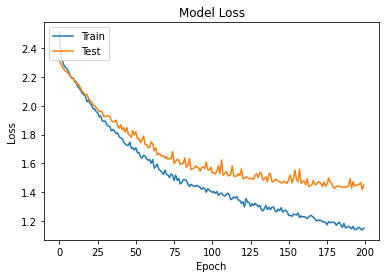

In [95]:
plt.plot(baselineModelHistory.history['loss'])
plt.plot(baselineModelHistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Plot *Model Accuracy*

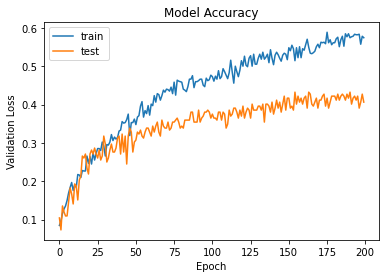

In [96]:
plt.plot(baselineModelHistory.history['accuracy'])
plt.plot(baselineModelHistory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
y_train_predict_Baseline = baselineModel.predict(x_traincnn)
y_test_predict_Baseline = baselineModel.predict(x_testcnn)

6/6 [==============================] - 0s 19ms/step


# Project Stops here...below is extra testing

## Training Results based on Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
#from sklearn.metrics import multilabel_confusion_matrix as cm

In [98]:
print(cm(y_train.argmax(axis=1),y_train_predict_Baseline.argmax(axis=1)))
print(cr(y_train.argmax(axis=1),y_train_predict_Baseline.argmax(axis=1)))

[[53  2  9  3  4  2  1  0  2  1]
 [ 3 68  3  1  4  0  1  1  0  1]
 [ 5  6 52 11  3  0  0  0  0  0]
 [ 3 11  9 50  2  0  0  0  0  2]
 [ 4 25  4  9 35  0  0  0  0  0]
 [ 1  0  1  0  0 57  3  4  1  2]
 [ 0  2  0  0  1  0 60  0  4 12]
 [ 5  3  3  4  0  7  1 42  2 11]
 [ 4  1  1  0  1 10  6 13 28  9]
 [ 5  3  0  1  0  1 11  5  4 49]]
              precision    recall  f1-score   support

           0       0.64      0.69      0.66        77
           1       0.56      0.83      0.67        82
           2       0.63      0.68      0.65        77
           3       0.63      0.65      0.64        77
           4       0.70      0.45      0.55        77
           5       0.74      0.83      0.78        69
           6       0.72      0.76      0.74        79
           7       0.65      0.54      0.59        78
           8       0.68      0.38      0.49        73
           9       0.56      0.62      0.59        79

    accuracy                           0.64       768
   macro avg       

## Validation Testing Results

In [99]:
print(cm(y_test.argmax(axis=1),y_test_predict_Baseline.argmax(axis=1)))
print(cr(y_test.argmax(axis=1),y_test_predict_Baseline.argmax(axis=1)))

[[ 9  2  1  2  2  1  0  0  0  2]
 [ 1  9  0  1  3  0  0  0  0  0]
 [ 2  1 11  4  0  0  0  1  0  0]
 [ 5  4  2  7  1  0  0  0  0  0]
 [ 3  7  0  4  5  0  0  0  0  0]
 [ 5  0  0  0  0 15  1  4  1  1]
 [ 0  1  0  0  0  0  9  2  0  5]
 [ 1  1  1  0  0  3  2  8  0  2]
 [ 2  1  0  2  1  4  2  6  2  3]
 [ 2  5  0  0  0  0  2  3  2  3]]
              precision    recall  f1-score   support

           0       0.30      0.47      0.37        19
           1       0.29      0.64      0.40        14
           2       0.73      0.58      0.65        19
           3       0.35      0.37      0.36        19
           4       0.42      0.26      0.32        19
           5       0.65      0.56      0.60        27
           6       0.56      0.53      0.55        17
           7       0.33      0.44      0.38        18
           8       0.40      0.09      0.14        23
           9       0.19      0.18      0.18        17

    accuracy                           0.41       192
   macro avg       

# Trying 1D CNN [from Chollet, page 291]

## Keep as competitor/proposed model

### Why this model is better:

1) Outperforms `baseline` model on both the **Training** set (increased **Capacity**) and the **Validation** test dataset.

2) It has 1 - (152,522/445,578) ~ **65.77%** fewer model parameters (**Complexity** has been reduced). Thereby it runs faster too (less **computations).

3) Our model uses **parameter regulation** through $l_1$-*norm* (on the exit MLP) to prevent *overfitting*.

In [104]:
from keras import layers

In [115]:
num_classes = len(labels[0].unique())

inputs = keras.Input(shape=(216,1))
x = layers.Conv1D(128, 32, kernel_initializer ='he_normal',activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(128, 6, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(64, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,
                       kernel_regularizer=regularizers.l1(0.01),
                       bias_regularizer=regularizers.l1(0.01),
                       activation='softmax')(x)
myCNNModel = keras.Model(inputs, outputs)

#opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
#myCNNModel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
myCNNModel.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

myCNNModel.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 216, 1)]          0         
                                                                 
 conv1d_48 (Conv1D)          (None, 185, 128)          4224      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 92, 128)          0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 92, 128)           0         
                                                                 
 conv1d_49 (Conv1D)          (None, 87, 128)           98432     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 43, 128)          0         
 g1D)                                                      

In [116]:
num_epochs = 200

tic = time.perf_counter()
myCNNHistory=myCNNModel.fit(x_traincnn, y_train, batch_size=16, epochs=num_epochs, validation_data=(x_testcnn, y_test))
toc = time.perf_counter()
print(f"Model took {toc - tic:0.4f} seconds to run!")

Epoch 1/200
48/48 [==============================] - 2s 31ms/step - loss: 17.7217 - accuracy: 0.1016 - val_loss: 3.3760 - val_accuracy: 0.0885
Epoch 2/200
48/48 [==============================] - 1s 28ms/step - loss: 3.3282 - accuracy: 0.1445 - val_loss: 3.7118 - val_accuracy: 0.0990
Epoch 3/200
48/48 [==============================] - 1s 28ms/step - loss: 3.1666 - accuracy: 0.1693 - val_loss: 3.1081 - val_accuracy: 0.1667
Epoch 4/200
48/48 [==============================] - 1s 28ms/step - loss: 2.9627 - accuracy: 0.2135 - val_loss: 2.8096 - val_accuracy: 0.1615
Epoch 5/200
48/48 [==============================] - 1s 28ms/step - loss: 2.7797 - accuracy: 0.2174 - val_loss: 2.6548 - val_accuracy: 0.2656
Epoch 6/200
48/48 [==============================] - 1s 29ms/step - loss: 2.6257 - accuracy: 0.2487 - val_loss: 2.5706 - val_accuracy: 0.2552
Epoch 7/200
48/48 [==============================] - 1s 28ms/step - loss: 2.5766 - accuracy: 0.2695 - val_loss: 2.4994 - val_accuracy: 0.2708
Epoch

48/48 [==============================] - 2s 36ms/step - loss: 1.1602 - accuracy: 0.5990 - val_loss: 1.8645 - val_accuracy: 0.4427
Epoch 116/200
48/48 [==============================] - 2s 41ms/step - loss: 1.1584 - accuracy: 0.6146 - val_loss: 1.8526 - val_accuracy: 0.3802
Epoch 117/200
48/48 [==============================] - 2s 40ms/step - loss: 1.1869 - accuracy: 0.5924 - val_loss: 1.9060 - val_accuracy: 0.4271
Epoch 118/200
48/48 [==============================] - 2s 39ms/step - loss: 1.1800 - accuracy: 0.6172 - val_loss: 1.8217 - val_accuracy: 0.4167
Epoch 119/200
48/48 [==============================] - 2s 40ms/step - loss: 1.1558 - accuracy: 0.6159 - val_loss: 1.7615 - val_accuracy: 0.4427
Epoch 120/200
48/48 [==============================] - 2s 38ms/step - loss: 1.1691 - accuracy: 0.6172 - val_loss: 1.8020 - val_accuracy: 0.4427
Epoch 121/200
48/48 [==============================] - 2s 35ms/step - loss: 1.1518 - accuracy: 0.6159 - val_loss: 1.7133 - val_accuracy: 0.4688
Epoch 

Epoch 172/200
48/48 [==============================] - 2s 37ms/step - loss: 0.9659 - accuracy: 0.6901 - val_loss: 1.9573 - val_accuracy: 0.4635
Epoch 173/200
48/48 [==============================] - 2s 35ms/step - loss: 0.9323 - accuracy: 0.6979 - val_loss: 1.9647 - val_accuracy: 0.4375
Epoch 174/200
48/48 [==============================] - 2s 35ms/step - loss: 0.9091 - accuracy: 0.7188 - val_loss: 2.0799 - val_accuracy: 0.4583
Epoch 175/200
48/48 [==============================] - 2s 35ms/step - loss: 0.8896 - accuracy: 0.7305 - val_loss: 1.9996 - val_accuracy: 0.4531
Epoch 176/200
48/48 [==============================] - 2s 35ms/step - loss: 0.9550 - accuracy: 0.7188 - val_loss: 2.0380 - val_accuracy: 0.4375
Epoch 177/200
48/48 [==============================] - 2s 35ms/step - loss: 0.8875 - accuracy: 0.7135 - val_loss: 1.9773 - val_accuracy: 0.4531
Epoch 178/200
48/48 [==============================] - 2s 38ms/step - loss: 0.8916 - accuracy: 0.7279 - val_loss: 2.0841 - val_accuracy:

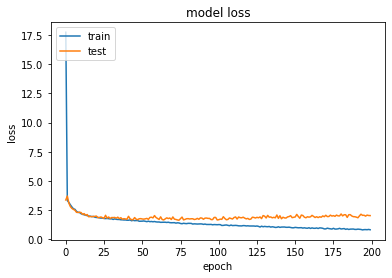

In [117]:
plt.plot(myCNNHistory.history['loss'])
plt.plot(myCNNHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

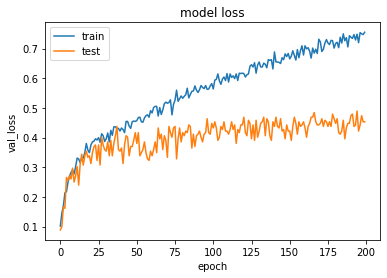

In [118]:
plt.plot(myCNNHistory.history['accuracy'])
plt.plot(myCNNHistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
y_train_predict_myCNNModel = myCNNModel.predict(x_traincnn)
y_test_predict_myCNNModel = myCNNModel.predict(x_testcnn)

6/6 [==============================] - 0s 16ms/step


In [120]:
print(cm(y_train.argmax(axis=1),y_train_predict_myCNNModel.argmax(axis=1)))
print( cr(y_train.argmax(axis=1),y_train_predict_myCNNModel.argmax(axis=1)))

[[59  6  1  5  4  0  0  1  1  0]
 [ 0 66  0  0 15  0  1  0  0  0]
 [ 1  7 46  6 17  0  0  0  0  0]
 [ 0  6  2 63  6  0  0  0  0  0]
 [ 0 12  0  3 62  0  0  0  0  0]
 [ 0  0  0  0  1 63  2  0  2  1]
 [ 0  1  0  0  0  0 77  0  0  1]
 [ 1  0  0  0  3  0  1 71  0  2]
 [ 0  1  0  0  1  0  5  1 64  1]
 [ 0  2  0  0  1  0  6  0  0 70]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86        77
           1       0.65      0.80      0.72        82
           2       0.94      0.60      0.73        77
           3       0.82      0.82      0.82        77
           4       0.56      0.81      0.66        77
           5       1.00      0.91      0.95        69
           6       0.84      0.97      0.90        79
           7       0.97      0.91      0.94        78
           8       0.96      0.88      0.91        73
           9       0.93      0.89      0.91        79

    accuracy                           0.83       768
   macro avg       

In [121]:
print(cm(y_test.argmax(axis=1),y_test_predict_myCNNModel.argmax(axis=1)))
print( cr(y_test.argmax(axis=1),y_test_predict_myCNNModel.argmax(axis=1)))

[[ 8  3  0  1  4  1  0  2  0  0]
 [ 0 10  1  1  2  0  0  0  0  0]
 [ 3  1  5  5  5  0  0  0  0  0]
 [ 1  4  0  9  4  1  0  0  0  0]
 [ 0  7  0  2 10  0  0  0  0  0]
 [ 2  0  0  0  0 15  2  1  3  4]
 [ 0  0  0  0  0  0 16  0  0  1]
 [ 0  1  1  0  1  1  3  6  2  3]
 [ 1  1  0  2  3  4  4  1  4  3]
 [ 1  2  0  3  1  0  3  2  1  4]]
              precision    recall  f1-score   support

           0       0.50      0.42      0.46        19
           1       0.34      0.71      0.47        14
           2       0.71      0.26      0.38        19
           3       0.39      0.47      0.43        19
           4       0.33      0.53      0.41        19
           5       0.68      0.56      0.61        27
           6       0.57      0.94      0.71        17
           7       0.50      0.33      0.40        18
           8       0.40      0.17      0.24        23
           9       0.27      0.24      0.25        17

    accuracy                           0.45       192
   macro avg       

# My MLP Model

## Keep as competitor model

### Why this model is better:

1) Outperforms `baseline` model on both the **Training** set (increased **Capacity**) and the **Validation** test dataset.

2) It has 1 - (186,634/445,578) ~ **58.11%** fewer model parameters (**Complexity** has been reduced). Thereby it runs faster too (less **computations**).

3) Our model uses **parameter regulation** through $l_2$-*norm* (on both input/output MLPs) to prevent *overfitting*.

4) Our model uses **early stopping** [1/2 the epochs!] to prevent *overfitting*.


In [122]:
def mlp_model():
    inputs = keras.Input(shape=(216,1))
    x = layers.Dense(128,
                     kernel_regularizer=regularizers.l2(0.01),
                     bias_regularizer=regularizers.l2(0.01),
                     activation='softmax')(inputs)
    x = layers.Conv1D(128, 6, activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(64, 6, activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(64, 6, activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes,
                           kernel_regularizer=regularizers.l2(0.01),
                           bias_regularizer=regularizers.l2(0.01),
                           activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

myMLPModel = mlp_model()

myMLPModel.compile(optimizer="rmsprop",
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

myMLPModel.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 216, 1)]          0         
                                                                 
 dense_12 (Dense)            (None, 216, 128)          256       
                                                                 
 conv1d_51 (Conv1D)          (None, 211, 128)          98432     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 105, 128)         0         
 g1D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 105, 128)          0         
                                                                 
 conv1d_52 (Conv1D)          (None, 100, 64)           49216     
                                                           

In [123]:
num_epochs = 100

tic = time.perf_counter()
myMLPHistory=myMLPModel.fit(x_traincnn, y_train, batch_size=16, epochs=num_epochs, validation_data=(x_testcnn, y_test))
toc = time.perf_counter()
print(f"Model took {toc - tic:0.4f} seconds to run!")

Epoch 1/100
48/48 [==============================] - 3s 58ms/step - loss: 2.4040 - accuracy: 0.0859 - val_loss: 2.3415 - val_accuracy: 0.0729
Epoch 2/100
48/48 [==============================] - 2s 48ms/step - loss: 2.1782 - accuracy: 0.1901 - val_loss: 2.0053 - val_accuracy: 0.2552
Epoch 3/100
48/48 [==============================] - 2s 44ms/step - loss: 1.8882 - accuracy: 0.2799 - val_loss: 1.8011 - val_accuracy: 0.3125
Epoch 4/100
48/48 [==============================] - 2s 45ms/step - loss: 1.8193 - accuracy: 0.2917 - val_loss: 1.7810 - val_accuracy: 0.2917
Epoch 5/100
48/48 [==============================] - 2s 42ms/step - loss: 1.7732 - accuracy: 0.3268 - val_loss: 1.7758 - val_accuracy: 0.3594
Epoch 6/100
48/48 [==============================] - 2s 43ms/step - loss: 1.7389 - accuracy: 0.3490 - val_loss: 1.7279 - val_accuracy: 0.3438
Epoch 7/100
48/48 [==============================] - 2s 43ms/step - loss: 1.7098 - accuracy: 0.3646 - val_loss: 1.7067 - val_accuracy: 0.3750
Epoch 

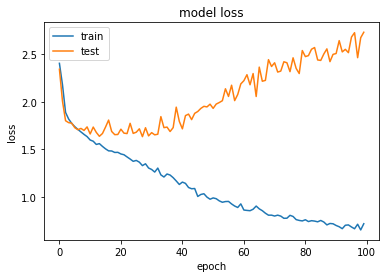

In [124]:
plt.plot(myMLPHistory.history['loss'])
plt.plot(myMLPHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

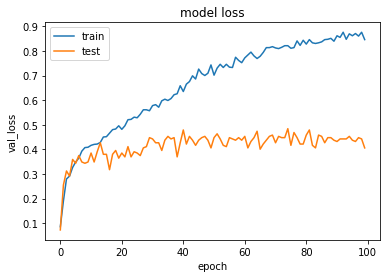

In [125]:
plt.plot(myMLPHistory.history['accuracy'])
plt.plot(myMLPHistory.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [126]:
y_train_predict_myMLPModel = myMLPModel.predict(x_traincnn)
y_test_predict_myMLPModel = myMLPModel.predict(x_testcnn)

6/6 [==============================] - 0s 24ms/step


In [127]:
print(cm(y_train.argmax(axis=1),y_train_predict_myMLPModel.argmax(axis=1)))
print( cr(y_train.argmax(axis=1),y_train_predict_myMLPModel.argmax(axis=1)))

[[76  0  0  0  1  0  0  0  0  0]
 [ 0 82  0  0  0  0  0  0  0  0]
 [ 1  1 74  0  1  0  0  0  0  0]
 [ 0  4  1 70  2  0  0  0  0  0]
 [ 0  2  0  0 75  0  0  0  0  0]
 [ 2  0  0  0  0 67  0  0  0  0]
 [ 0  0  0  0  0  0 79  0  0  0]
 [ 0  1  0  0  0  1  0 73  2  1]
 [ 0  0  0  0  0  0  0  0 72  1]
 [ 0  0  0  0  0  0  0  0  0 79]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        77
           1       0.91      1.00      0.95        82
           2       0.99      0.96      0.97        77
           3       1.00      0.91      0.95        77
           4       0.95      0.97      0.96        77
           5       0.99      0.97      0.98        69
           6       1.00      1.00      1.00        79
           7       1.00      0.94      0.97        78
           8       0.97      0.99      0.98        73
           9       0.98      1.00      0.99        79

    accuracy                           0.97       768
   macro avg       

In [128]:
print(cm(y_test.argmax(axis=1),y_test_predict_myMLPModel.argmax(axis=1)))
print( cr(y_test.argmax(axis=1),y_test_predict_myMLPModel.argmax(axis=1)))

[[ 9  3  0  1  4  0  1  0  1  0]
 [ 0 11  1  0  2  0  0  0  0  0]
 [ 4  0  9  4  2  0  0  0  0  0]
 [ 4  2  1 10  2  0  0  0  0  0]
 [ 1 11  0  0  7  0  0  0  0  0]
 [ 6  0  0  0  0  9  2  1  6  3]
 [ 0  0  0  0  0  2  8  0  2  5]
 [ 1  0  0  1  0  2  2  2  5  5]
 [ 3  1  0  0  0  3  0  2  9  5]
 [ 2  2  0  0  0  0  2  3  4  4]]
              precision    recall  f1-score   support

           0       0.30      0.47      0.37        19
           1       0.37      0.79      0.50        14
           2       0.82      0.47      0.60        19
           3       0.62      0.53      0.57        19
           4       0.41      0.37      0.39        19
           5       0.56      0.33      0.42        27
           6       0.53      0.47      0.50        17
           7       0.25      0.11      0.15        18
           8       0.33      0.39      0.36        23
           9       0.18      0.24      0.21        17

    accuracy                           0.41       192
   macro avg       